In [30]:
%load_ext autoreload
%autoreload 2
import os, sys
import collections
import re
import numpy as np
import json
import pandas as pd

# basedir = "/cbscratch/franco/trans-eqtl/simulation/ldpruned2/15064_450_10_800_30_100_100_0.01_0.5_0.0_1.0_0.6_4.0_0.1_20_0.02/"
# basedir = "/cbscratch/franco/trans-eqtl/simulation/ldpruned_saikat_bg/12639_450_10_800_30_100_100_0.01_0.5_0.0_1.0_0.6_4.0_0.1_20_0.02/"
basedir = "/cbscratch/franco/trans-eqtl/simulation/gtex_v6_ldpruned/12639_450_10_800_30_100_100_0.01_0.5_0.0_1.0_0.6_4.0_0.1_20_0.02/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
# load simulation data. We need:
# - trans-eqtl SNPs
# - trans-eqtl cis target gene
# - trans-eqtl trans target genes

def read_simtrans(transfile):
    res_dict = collections.defaultdict(dict)
    with open(transfile) as instream:
        for line in instream:
            arr = line.strip().split()
            snpid = arr[1]
            cisgene = arr[3]
            translist = arr[4].split(",")
            transgenes = ["ENSG{:06d}".format(int(x)) for x in translist]
            res_dict[snpid]["targets"] = transgenes
            res_dict[snpid]["cistarget"] = cisgene
    return res_dict


In [32]:
# TARGGEN_FIELDS = ['ensembl_id', 'pval']
# class TargGen(collections.namedtuple('_TargGen', TARGGEN_FIELDS)):
#     __slots__ = ()

simname = "sim001"
trans_dict = dict()    
simdir = os.path.join(basedir, simname)    
transfile = os.path.join(simdir, "input", "expression.trans")
trans_dict = read_simtrans(transfile)

In [33]:
genepos_file = os.path.join(simdir, "input", "expression.genepos")
genotype_file = os.path.join(simdir, "input", "genotype.dosage.txt")

def map_cis_genes(genepos_file, genotype_file):
    genelist = list()
    snplist  = list()
    cis_dict = dict()
    with open(genepos_file) as fin:
        next(fin)
        for line in fin:
            genelist.append(line.rstrip().split()[0])
    with open(genotype_file) as fin:
        for line in fin:
            snplist.append(line.rstrip().split()[1])
    if len(genelist) == len(snplist):
        cis_dict = dict(zip(snplist, genelist))
    else:
        print("Error, gene and snp numbers are not equal")
        raise
    return cis_dict

cis_dict = map_cis_genes(genepos_file, genotype_file)

In [34]:
def load_transtarget_genes(simdir, paramsdir, mode):
    target_genes_pvals = collections.defaultdict(lambda: collections.defaultdict(dict))
    target_gene_dir = os.path.join(simdir, paramsdir)
    if mode == "knn":
        # targfiles = [os.path.join(target_gene_dir,x) for x in os.listdir(target_gene_dir) if x.endswith("gene_snp_list_knn.txt")]
        targfile = os.path.join(target_gene_dir,"gene_snp_list_knn.txt")
    if mode == "cclm":
        targfile = os.path.join(target_gene_dir,"gene_snp_list.txt")
    if mode == "jpa":
        targfile = os.path.join(target_gene_dir,"all_gene_snp_list.txt")
#     for ff in targfiles:
    if os.path.exists(targfile):
        with open(targfile) as fin:
            next(fin)
            for line in fin:
                arr = line.split("\t")
                variant_id = arr[1]
                ensembl_id = arr[0]
                pval = float(arr[2])
                target_genes_pvals[variant_id][ensembl_id] = pval
    else:
        print("file not found", targfile)
    return target_genes_pvals

def load_rr_result(simdir, paramsdir):
    trans_eqtls_dict = collections.defaultdict(lambda: collections.defaultdict(dict))
    ff = os.path.join(simdir, paramsdir, "rr.txt")
    if os.path.exists(ff):
        with open(ff) as fin:
            next(fin)
            for line in fin:
                arr = line.split("\t")
                snp = arr[0]
                maf = float(arr[3])
                pval = float(arr[7])
                trans_eqtls_dict[snp]["pval"] = pval
                trans_eqtls_dict[snp]["maf"] = pval
    else:
        print("Error, file does not exist")
        raise
    return trans_eqtls_dict


In [35]:
TargetedGenes = dict()
TargetedGenes_meqtl = dict()
mode = "cclm" # "knn"
params_tejaas = "tejaas/permnull_sb0.2/raw_knn30/peer0"

TranseQTLs_rr    = load_rr_result(simdir, params_tejaas)
TargetedGenes_rr = load_transtarget_genes(simdir, params_tejaas, mode)

# Target - Gene discovery Section

### AUC of target genes for each simulated trans-eQTL

100 12539 12639 0.7533238389113063 0.000128942
100 12539 12639 0.9360598148587703 0.000211626
100 12539 12639 0.9450399556926973 3.80823e-05
100 12539 12639 0.9539591739852836 6.02697e-05
100 12539 12639 0.7765503599968351 0.0908547
100 12539 12639 0.8945185536830446 0.000413348
100 12539 12639 0.8588100324392752 0.00428057
100 12539 12639 0.9684563652187672 3.25079e-05
100 12539 12639 0.86069942242266 0.00504933
100 12539 12639 0.8841229527652503 0.00075284
100 12539 12639 0.8913577023498696 0.00792694
100 12539 12639 0.90142574570773 9.73937e-05
100 12539 12639 0.8535453754252709 0.00367526
100 12539 12639 0.8830856871587941 6.74984e-05
100 12539 12639 0.8937993512144948 0.00152122
100 12539 12639 0.8660329139963605 0.0023788
100 12539 12639 0.9583859482553999 0.000605523
100 12539 12639 0.9630777751404382 4.26941e-05
100 12539 12639 0.8208893108632012 0.0135657
100 12539 12639 0.9558580583906954 0.000615804
100 12539 12639 0.9622565076350977 0.000221186
100 12539 12639 0.58941292823

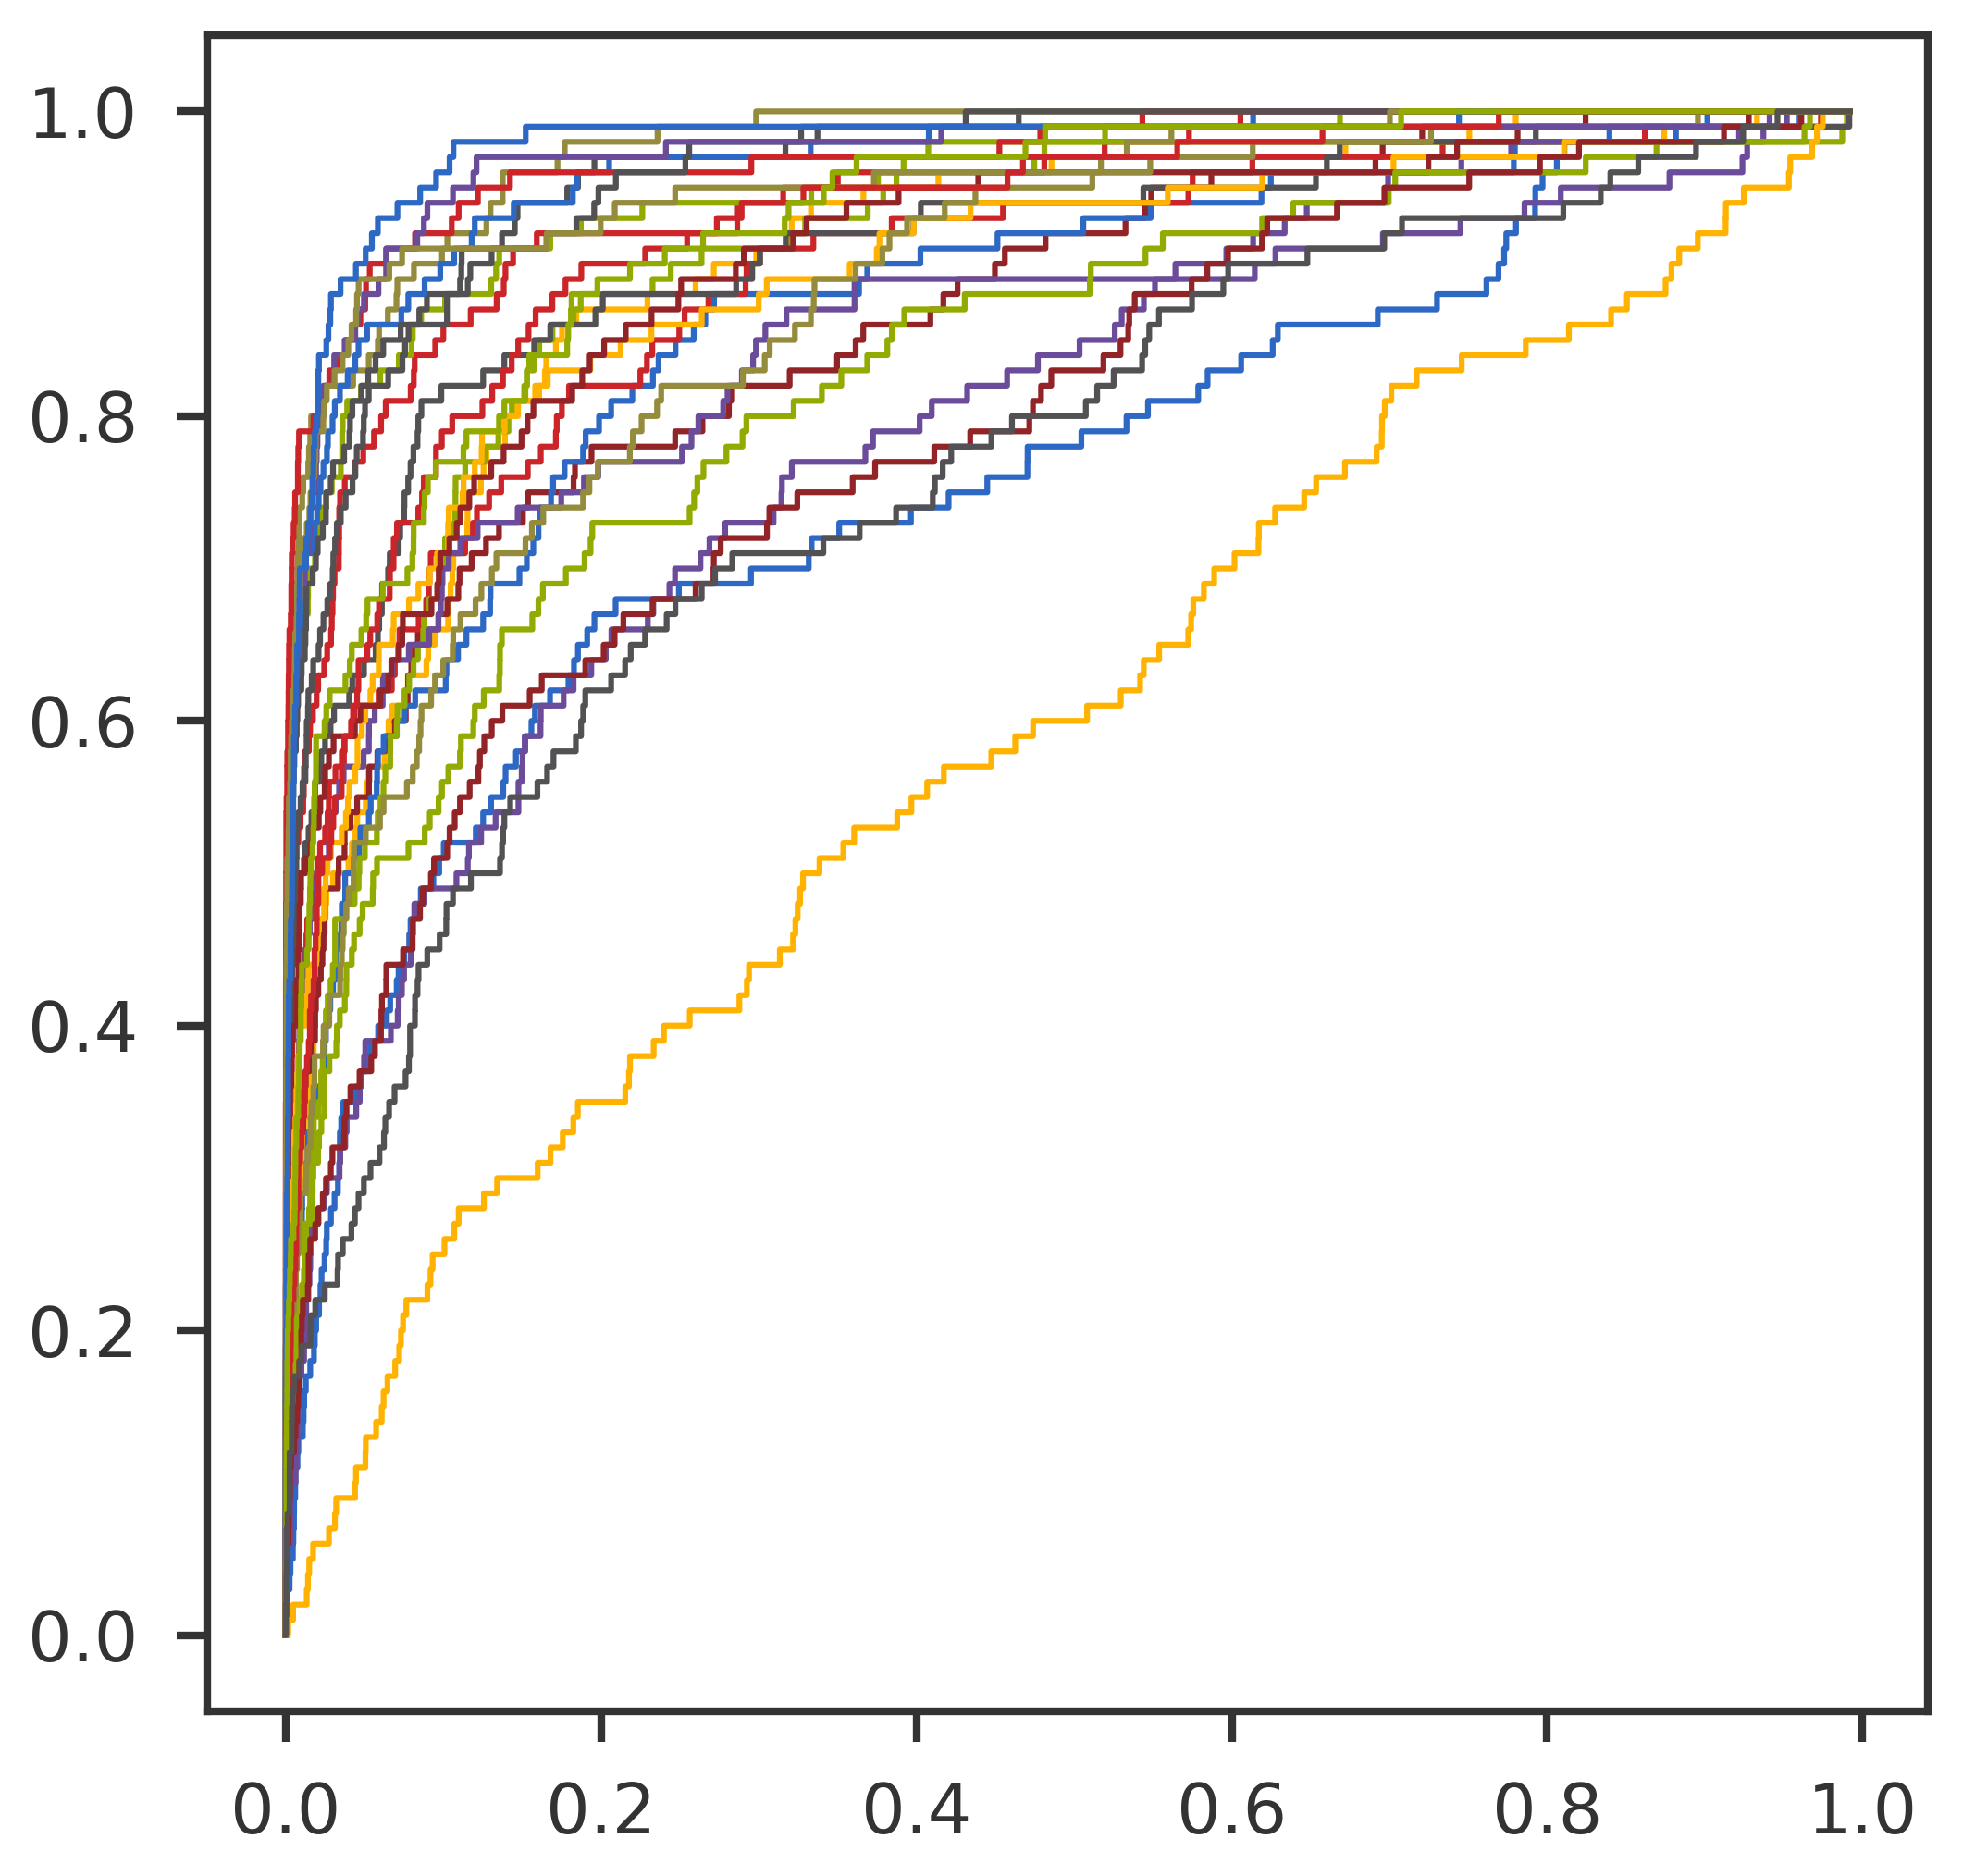

Tejaas found 28/30
If not all trans-eQTL were found it's because Tejaas calculates gene pvalues 
only for those that pass a pval thres first
Those trans-eQTLs might have a high pval :(


In [140]:
########################
# Target genes discovery AUCs
########################

target_genes = TargetedGenes_rr #["cclm"]

found = 0
foundsnplist = list()
auc_snp_pval = list()
for snp in target_genes:
    if snp in trans_dict:
        found += 1
#         print(f"found {snp}")
        foundsnplist.append(snp)
        sorted_list = [k for k, v in sorted(target_genes[snp].items(), key=lambda item: item[1])]
        tp = 0
        fp = 0
        tpr = list()
        fpr = list()
        for i,gene in enumerate(sorted_list):
            if gene in trans_dict[snp]['targets']:
                tp += 1
            else:
                fp += 1
            tpr.append(tp)
            fpr.append(fp)
        tpr = np.array(tpr)/len(trans_dict[snp]['targets'])
        fpr = np.array(fpr)/len(target_genes[snp].keys())
        auc = np.trapz(tpr, fpr)
        print(tp, fp, tp+fp, auc, rr_dict[snp]['pval'])
        auc_snp_pval.append((auc, rr_dict[snp]['pval']))
        plt.plot(fpr, tpr)
plt.show()
print(f"Tejaas found {found}/{len(trans_dict.keys())}")
print("If not all trans-eQTL were found it's because Tejaas calculates gene pvalues \nonly for those that pass a pval thres first")
print("Those trans-eQTLs might have a high pval :(")


28


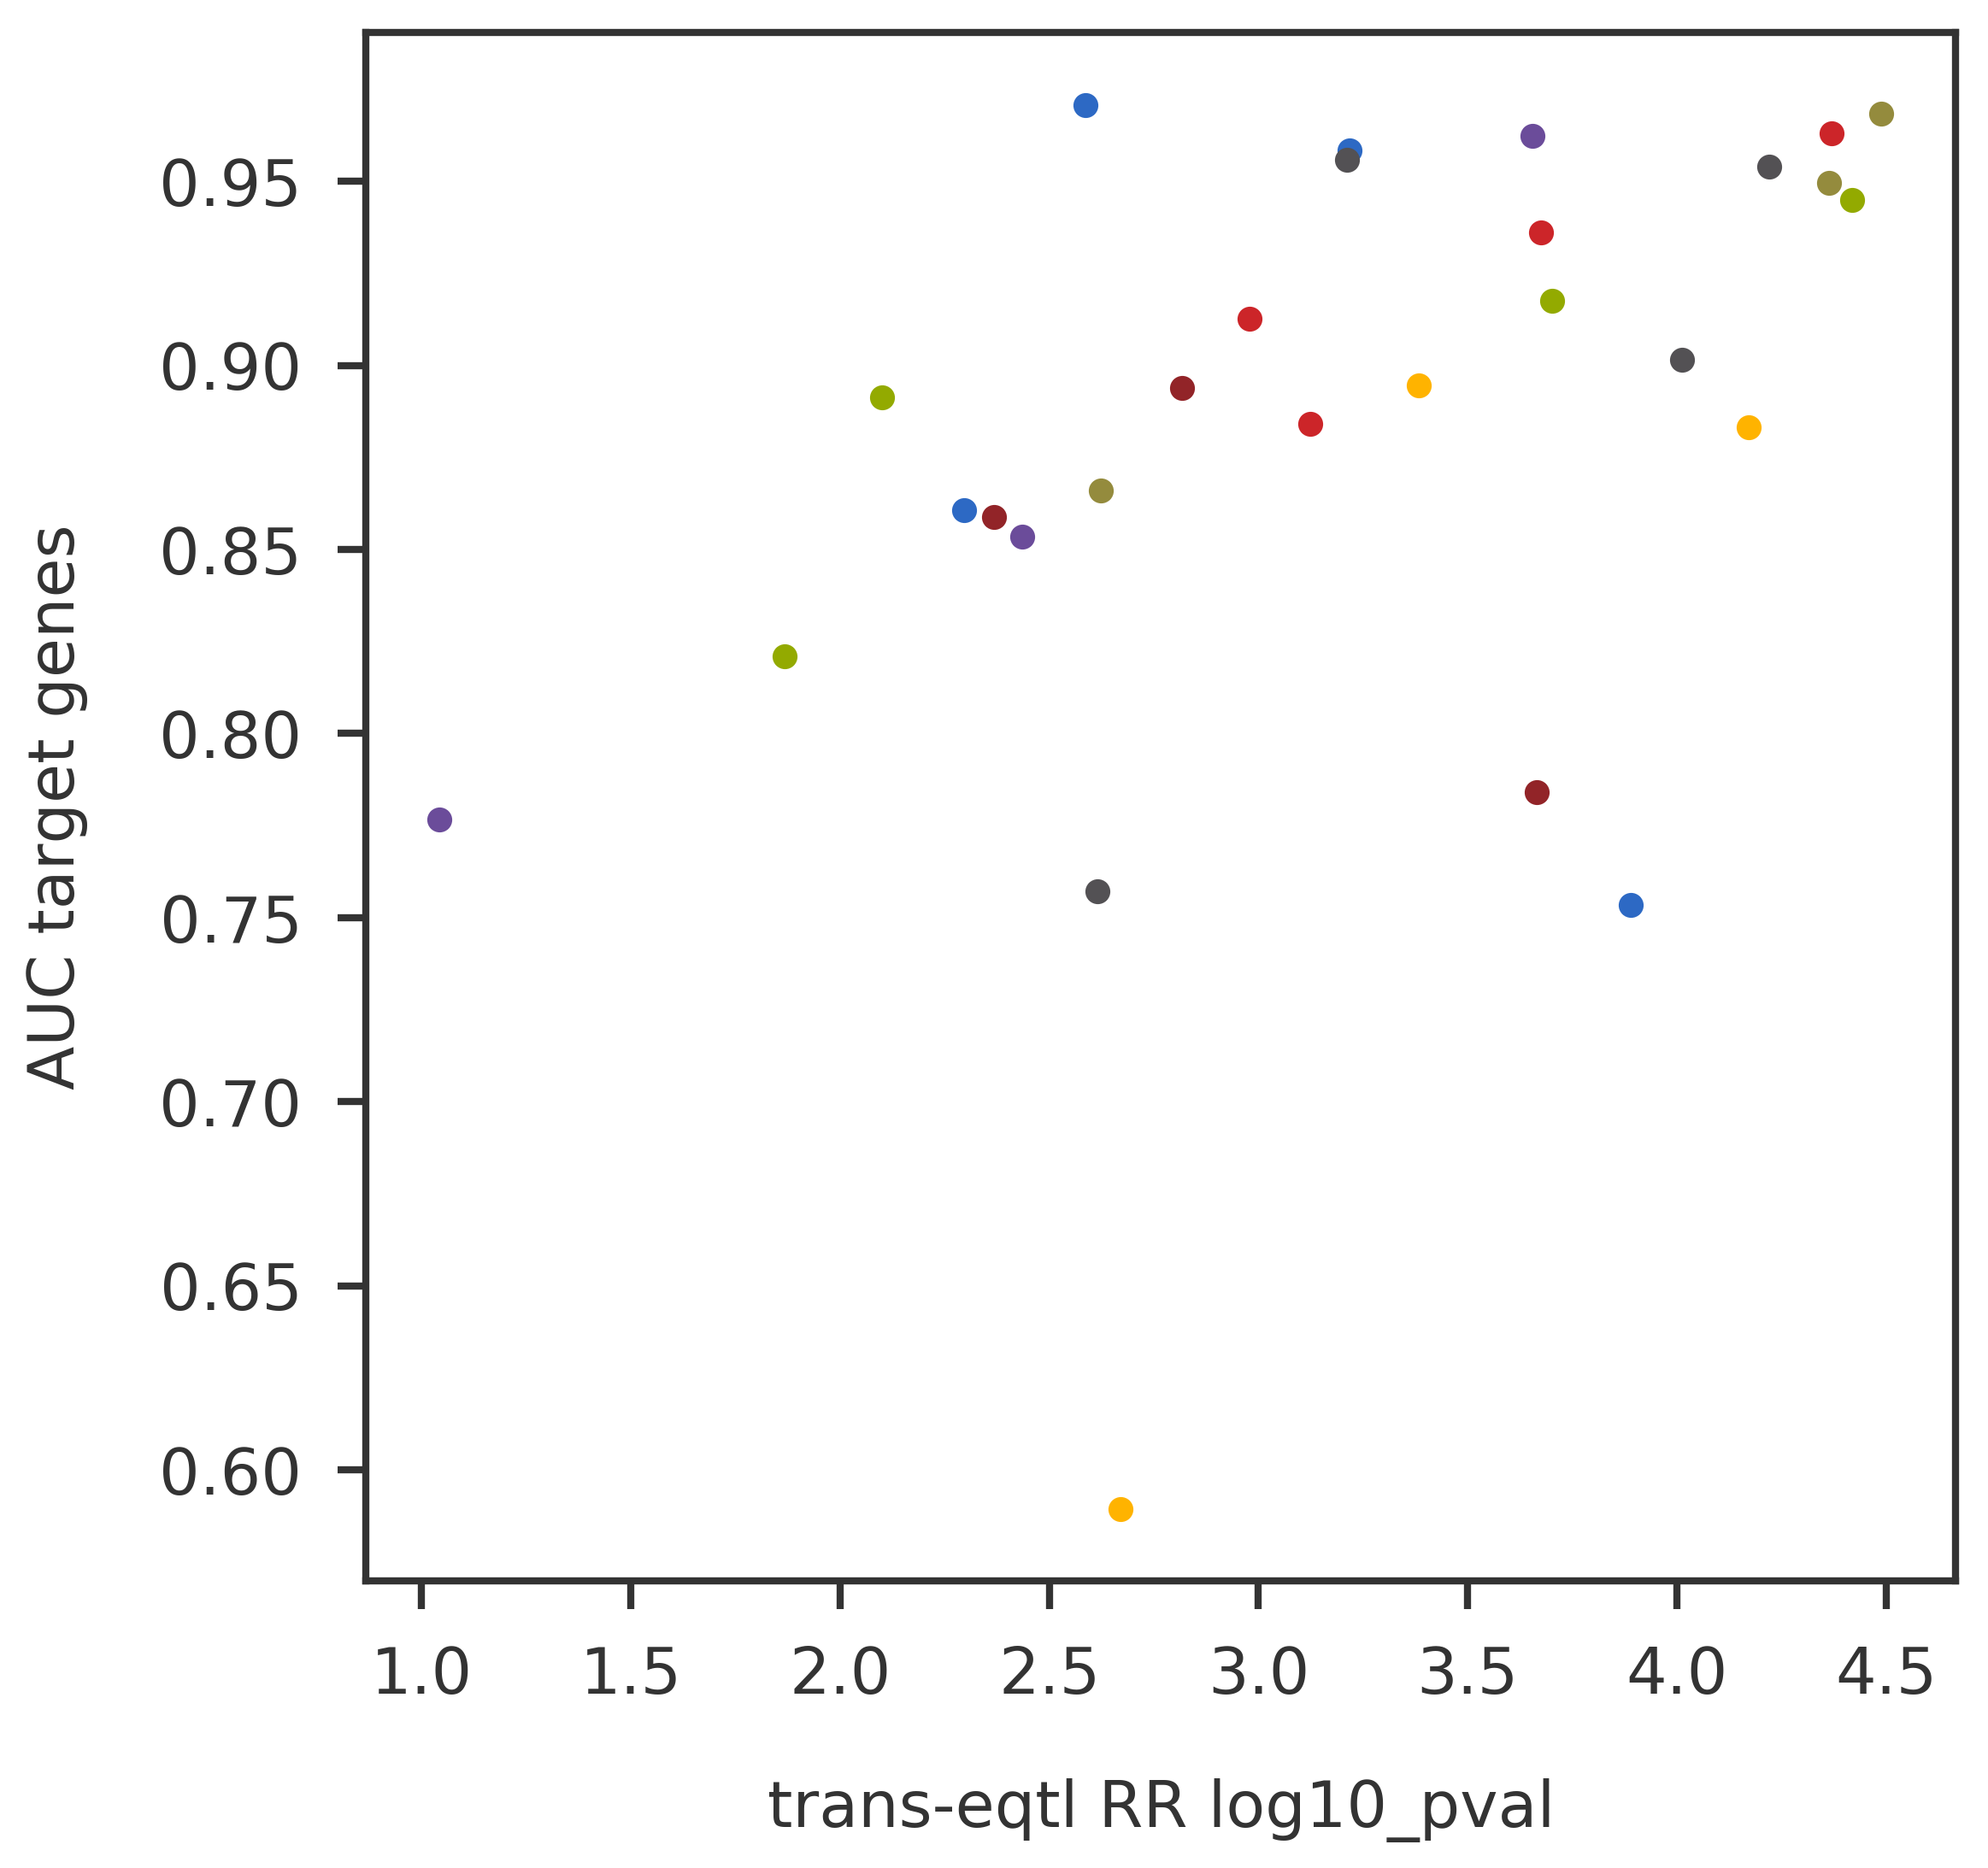

In [143]:
print(len(auc_snp_pval))
for auc, pval in auc_snp_pval:
    plt.scatter(-np.log10(pval), auc)
    plt.ylabel("AUC target genes")
    plt.xlabel("trans-eqtl RR log10_pval")
#     plt.scatter(pval, auc)
plt.show()

# Target-gene discovery with trans-eQTL snp cutoffs
### This considers even false positive trans-eQTLs

In [36]:
########################
# rework on BH procedure
########################

######
# First, prepare the (snp,gene,pval) pairs by filtering the significant RR snps (trans-eqtls)

rr_dict = TranseQTLs_rr
target_dict = TargetedGenes_rr

## First, get an ordered list of all snp-gene-pvalues
all_snp_gene_pairs = [(snp, geneid, target_dict[snp][geneid]) for snp in target_dict for geneid in target_dict[snp]]

snp_gene_pairs_list = list()
snp_cutoff = 0.0001
for snp in target_dict:
    if rr_dict[snp]['pval'] <= snp_cutoff:
        snp_gene_pairs_list.append([(snp, geneid, target_dict[snp][geneid]) for geneid in target_dict[snp]])

# snp_cutoff = 0.0001
# pass_pairs = list()
# for snpid, geneid, pval in snp_gene_pairs:
#     if rr_dict[snpid]['pval'] <= snp_cutoff:
#         pass_pairs.append((snpid, geneid, pval))
        
print(len(snp_gene_pairs_list), len(all_snp_gene_pairs))

7 38713250


In [37]:
len(target_dict.keys())

3063

In [57]:
sort_test = sorted(snp_gene_pairs_list[0], key=lambda item: item[2])
# len(set([x[2] for x in sort_test]))
rank_map  = {j: i for i, j in enumerate(sorted(set([x[2] for x in sort_test])))}

In [73]:
def bh_procedure(snp_gene_pval, target_fdr=0.5):
    print("Calculating FDR ... sorting {:d} SNP-gene pairs".format(len(snp_gene_pval)))
    sorted_pairs   = sorted(snp_gene_pval, key=lambda item: item[2])
    n_tests        = len(sorted_pairs) # NOT equivalent to ntrans-eqtls * ngenes, because ntrans is filtered
    bh_index_limit = -1
    for i, snp_pval in enumerate(sorted_pairs[::-1]):
        bh_factor = ( (n_tests-i) / n_tests ) * target_fdr
        if snp_pval[2] > bh_factor:
            continue
        else:
            bh_index_limit = n_tests - i - 1
            break
    if bh_index_limit < 0:
        self.logger.debug("No significant SNP-gene pairs @ {:f} FDR for SNP".format(target_fdr))
        return [], []
    else:
        pass_fdr  = [ sorted_pairs[i] for i in range(bh_index_limit + 1)]
        adj_pvals = [ sorted_pairs[i][2] * ( n_tests / ( i + 1 ) ) for i in range(n_tests)] # equiv to report FDR
        return pass_fdr, adj_pvals[:len(pass_fdr)]
    
def bh_procedure_ties(snp_gene_pval, target_fdr=0.5):
    print("Calculating FDR ... sorting {:d} SNP-gene pairs".format(len(snp_gene_pval)))
    sorted_pairs   = sorted(snp_gene_pval, key=lambda item: item[2])
    n_tests        = len(sorted_pairs) # NOT equivalent to ntrans-eqtls * ngenes, because ntrans is filtered
    bh_index_limit = -1
    rank_map  = {j: i for i, j in enumerate(sorted(set([x[2] for x in sorted_pairs])))}
    for i, snp_pval in enumerate(sorted_pairs[::-1]):
        bh_factor = ( (rank_map[snp_pval[2]] + 1) / n_tests ) * target_fdr
        if snp_pval[2] > bh_factor:
            continue
        else:
            bh_index_limit = n_tests - i - 1
            break
    if bh_index_limit < 0:
        self.logger.debug("No significant SNP-gene pairs @ {:f} FDR for SNP".format(target_fdr))
        return [], []
    else:
        pass_fdr  = [ sorted_pairs[i] for i in range(bh_index_limit + 1)]
        adj_pvals = [ sorted_pairs[i][2] * ( n_tests / ( rank_map[sorted_pairs[i][2]] + 1 ) ) for i in range(n_tests)] # equiv to report FDR
        return pass_fdr, adj_pvals[:len(pass_fdr)]
    
pass_fdr, adj_pvals = bh_procedure( snp_gene_pairs_list[1], target_fdr=0.9)
pass_fdrT, adj_pvalsT = bh_procedure_ties( snp_gene_pairs_list[1], target_fdr=0.9)

Calculating FDR ... sorting 12639 SNP-gene pairs
Calculating FDR ... sorting 12639 SNP-gene pairs


In [74]:
print(len(pass_fdr))
print(len(pass_fdrT))

2782
2770


In [76]:
print(adj_pvals[:10])
print(adj_pvalsT[:10])

[4.243304109e-09, 0.001062232116, 0.023065669440000002, 0.0236265566625, 0.04620515064, 0.0386551176, 0.033854103171428576, 0.0463941352875, 0.06559781433333334, 0.059191596750000006]
[4.243304109e-09, 0.001062232116, 0.023065669440000002, 0.0236265566625, 0.04620515064, 0.0386551176, 0.033854103171428576, 0.0463941352875, 0.06559781433333334, 0.059191596750000006]


In [54]:
#######################################
# BH procedure over all snp-gene pairs together
#######################################

sorted_snp_gene_pval = pass_pairs
target_fdr=0.1
n_tests = len(sorted_snp_gene_pval) # equivalent to ntrans-eqtls * ngenes
pass_snps = list()
bh_index_limit = -1
for i, snp_pval in enumerate(sorted_snp_gene_pval[::-1]):
    bh_factor = ((n_tests-i)/n_tests)*target_fdr
    if snp_pval[2] > bh_factor:
        # pass_snps.append(snp_pval)
        continue
    else:
        bh_index_limit = n_tests-i-1
        break
pass_fdr = [sorted_snp_gene_pval[i] for i in range(bh_index_limit)]
adj_pvals = [sorted_snp_gene_pval[i][2]*(n_tests/(i+1)) for i in range(n_tests)]
        
print(bh_index_limit)
print("Reached pval", pass_pairs[bh_index_limit])
print("target BH limit", ((bh_index_limit)/n_tests)*target_fdr)

# 106
# Reached pval ('rs185240114', 'ENSG001928', 2.90476e-07)
# target BH limit 2.7380806313084023e-07

150
Reached pval ('rs6502892', 'ENSG009227', 0.000168552)
target BH limit 0.00016954325048319828


In [55]:
lim = 200
counter = 0
for i,x in enumerate(pass_pairs):
    print(i,x, adj_pvals[i])
    counter += 1
    if counter > lim:
        break

0 ('rs113721499', 'ENSG004520', 1.11022e-16) 9.822449406e-12
1 ('rs12302233', 'ENSG008570', 1.11022e-16) 4.911224703e-12
2 ('rs6502892', 'ENSG010678', 1.64868e-13) 4.862122188e-09
3 ('rs4532197', 'ENSG002960', 3.35731e-13) 7.42578219075e-09
4 ('rs80126140', 'ENSG002406', 9.86544e-13) 1.74565014624e-08
5 ('rs113721499', 'ENSG005204', 2.97062e-12) 4.380327721e-08
6 ('rs10961474', 'ENSG006586', 6.15625e-11) 7.780884375e-07
7 ('rs181647', 'ENSG007576', 1.41255e-09) 1.5621567018750002e-05
8 ('rs12302233', 'ENSG002817', 8.06892e-09) 7.932017324e-05
9 ('rs113721499', 'ENSG002704', 3.06599e-08) 0.00027125733327
10 ('rs80126140', 'ENSG007833', 9.28812e-08) 0.0007470434915999999
11 ('rs4532197', 'ENSG011541', 1.68088e-07) 0.0012392708019999998
12 ('rs113721499', 'ENSG011748', 6.04087e-07) 0.004111183780846154
13 ('rs6502892', 'ENSG007313', 8.78104e-07) 0.005549178228
14 ('rs113721499', 'ENSG010537', 1.04962e-06) 0.006190868683999999
15 ('rs12302233', 'ENSG000499', 1.06254e-06) 0.00587538133875
1

In [ ]:
#######################################
# BH procedure over snp-gene for every trans-eQTL separately
#######################################

################### TODO, change everything
rr_dict = TranseQTLs_rr
target_dict = TargetedGenes_rr

## First, get an ordered list of all snp-gene-pvalues
snp_gene_pairs = [(snp, geneid, target_dict[snp][geneid]) for snp in target_dict for geneid in target_dict[snp]]
sorted_pairs = sorted(snp_gene_pairs, key=lambda item: item[2])

snp_cutoff = 0.0001
pass_pairs = list()
for snpid, geneid, pval in sorted_pairs:
    if rr_dict[snpid]['pval'] <= snp_cutoff:
        pass_pairs.append((snpid, geneid, pval))
        
print(len(pass_pairs), len(snp_gene_pairs), len(pass_pairs)/len(snp_gene_pairs))

#######################################

sorted_snp_gene_pval = pass_pairs
target_fdr=0.1
n_tests = len(sorted_snp_gene_pval) # equivalent to ntrans-eqtls * ngenes
pass_snps = list()
bh_index_limit = -1
for i, snp_pval in enumerate(sorted_snp_gene_pval[::-1]):
    bh_factor = ((n_tests-i)/n_tests)*target_fdr
    if snp_pval[2] > bh_factor:
        # pass_snps.append(snp_pval)
        continue
    else:
        bh_index_limit = n_tests-i-1
        break
pass_fdr = [sorted_snp_gene_pval[i] for i in range(bh_index_limit)]
adj_pvals = [sorted_snp_gene_pval[i][2]*(n_tests/(i+1)) for i in range(n_tests)]
        
print(bh_index_limit)
print("Reached pval", pass_pairs[bh_index_limit])
print("target BH limit", ((bh_index_limit)/n_tests)*target_fdr)


In [148]:
def bh_procedure_targetgenes(sorted_snp_gene_pval, target_fdr):
    n_tests = len(sorted_snp_gene_pval)
    pass_snps = list()
    for i, snp_pval in enumerate(sorted_snp_gene_pval):
        bh_factor = ((i+1)/n_tests)*target_fdr
        fdr_val = snp_pval[2] / bh_factor
        if snp_pval[2] <= bh_factor:
            pass_snps.append(snp_pval+(fdr_val,))
        else:
            break
    return pass_snps

target_fdr = 0.99
rr_dict = TranseQTLs_rr
target_dict = TargetedGenes_rr 

## First, get an ordered list of all snp-gene-pvalues
snp_gene_pairs = [(snp, geneid, target_dict[snp][geneid]) for snp in target_dict for geneid in target_dict[snp]]
sorted_pairs = sorted(snp_gene_pairs, key=lambda item: item[2])

pass_rr_targets = bh_procedure_targetgenes(sorted_pairs, target_fdr)
print(len(pass_rr_targets))

10687
